<a href="https://colab.research.google.com/github/JMSandoval87/DnD_Map_Gen_With_Random_Encounter_Builder_Placement/blob/main/DnD_Map_Gen_With_Random_Encounter_Builder_Placement_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The tiles used in our map generator can be found here: https://github.com/jjones307/CS4200Stuff

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#drive path for sample_data: '/content/sample_data/'
#drive path for folder in mounted drive: '/content/drive/MyDrive/the name of the folder where you put the tiles/'
drivePath = '/content/sample_data/'

In [ ]:
import cv2;
from google.colab.patches import cv2_imshow
from PIL import Image;
from typing import List;

#this class definition was left in for posterity
#we ended up not using it
class Tile:
  def __init__(self, image: Image, tileType: str, sides: List[int]):
    self.image = image;
    #tileType is the a descriptor of the tile used to help validate placement
    #  There are five types:
    #   -corridors are the hallways between rooms
    #   -connectors are the entry points where corridors connect to rooms
    #   -floor is a floor tile in a room
    #   -wall is a wall tile in a room
    #   -empty is a black tile for filling in space
    self.tileType = tileType;
    #sides are indexed [left, top, right, bottom]
    self.sides = sides;

  def getImage(self):
    #self.image.show();
    return Image.open(self.image);
  
  def getLeftSide(self):
    return self.sides[0];
  
  def getTopSide(self):
    return self.sides[1];
  
  def getRightSide(self):
    return self.sides[2];

  def getBottomSide(self):
    return self.sides[3];

#img = Image.open('/content/drive/MyDrive/4200 Tiles/corridor_1b.jpg');
#img = cv2.imread('/content/drive/MyDrive/4200 Tiles/corridor_1b.jpg');
#test = Tile(img, 'corridor', [1,0,1,0]);
#test.getImage();
#print(test.tileType);
#print(test.getLeftSide());
#print(test.getTopSide());
#print(test.getRightSide());
#print(test.getBottomSide());

In [ ]:
from math import sqrt
from random import random
from random import randrange
from random import choice


class dungMap:
    def __init__(self, tile):
        self.tile = tile

    def getTile(self):
        return self.tile


class room:
    def __init__(self, row, col, height, width):
        self.row = row
        self.col = col
        self.height = height
        self.width = width


class mapGenerator:
    def __init__(self, width, height):
        self.maxLeafSize = 18
        self.width = width
        self.height = height
        self.leaves = []
        self.level = []
        self.rooms = []

        for i in range(self.height):
            row = []
            for j in range(self.width):
                row.append(dungMap("0"))

            self.level.append(row)

    def randomSplit(self, minRow, minCol, maxRow, maxCol):
        segmentHeight = maxRow - minRow
        segmentWidth = maxCol - minCol

        if segmentHeight < self.maxLeafSize and segmentWidth < self.maxLeafSize:
            self.leaves.append((minRow, minCol, maxRow, maxCol))
        elif segmentHeight < self.maxLeafSize and segmentWidth >= self.maxLeafSize:
            self.verticalSplit(minRow, minCol, maxRow, maxCol)
        elif segmentHeight >= self.maxLeafSize and segmentWidth < self.maxLeafSize:
            self.horizontalSplit(minRow, minCol, maxRow, maxCol)
        else:
            if random() < 0.5:
                self.horizontalSplit(minRow, minCol, maxRow, maxCol)
            else:
                self.verticalSplit(minRow, minCol, maxRow, maxCol)

    def horizontalSplit(self, minRow, minCol, maxRow, maxCol):
        split = (minRow + maxRow) // 2 + choice((-2, -1, 0, 1, 2))
        self.randomSplit(minRow, minCol, split, maxCol)
        self.randomSplit(split + 1, minCol, maxRow, maxCol)

    def verticalSplit(self, minRow, minCol, maxRow, maxCol):
        split = (minCol + maxCol) // 2 + choice((-2, -1, 0, 1, 2))
        self.randomSplit(minRow, minCol, maxRow, split)
        self.randomSplit(minRow, split + 1, maxRow, maxCol)

    def makeRooms(self):
        for leaf in self.leaves:
            if random() > 0.60: continue
            sectionWidth = leaf[3] - leaf[1]
            sectionHeight = leaf[2] - leaf[0]

            roomWidth = round(randrange(50, 100) / 100 * sectionWidth)
            roomHeight = round(randrange(50, 100) / 100 * sectionHeight)

            if sectionHeight > roomHeight:
                roomRow = leaf[0] + randrange(sectionHeight - roomHeight)
            else:
                roomRow = leaf[0]

            if sectionWidth > roomWidth:
                roomCol = leaf[1] + randrange(sectionWidth - roomWidth)
            else:
                roomCol = leaf[1]

            self.rooms.append(room(roomRow, roomCol, roomHeight, roomWidth))
            for i in range(roomRow, roomRow + roomHeight):
                for j in range(roomCol, roomCol + roomWidth):
                    self.level[i][j] = dungMap('.')

    def adjCheck(self, room1, room2):
        adjRows = []
        adjCols = []
        for r in range(room1.row, room1.row + room1.height):
            if r >= room2.row and r < room2.row + room2.height:
                adjRows.append(r)

        for c in range(room1.col, room1.col + room1.width):
            if c >= room2.col and c < room2.col + room2.width:
                adjCols.append(c)

        return (adjRows, adjCols)

    def roomDistance(self, room1, room2):
        centre1 = (room1.row + room1.height // 2, room1.col + room1.width // 2)
        centre2 = (room2.row + room2.height // 2, room2.col + room2.width // 2)
        return sqrt((centre1[0] - centre2[0]) ** 2 + (centre1[1] - centre2[1]) ** 2)

    def generateHallways(self, room1, room2):
        if room2[2] == 'rows':
            row = choice(room2[1])
            if room1.col + room1.width < room2[0].col:
                startCol = room1.col + room1.width
                endCol = room2[0].col
            else:
                startCol = room2[0].col + room2[0].width
                endCol = room1.col
            for c in range(startCol, endCol):
                self.level[row][c] = dungMap('1')

            if endCol - startCol >= 4:
                self.level[row][startCol] = dungMap('1')
                self.level[row][endCol - 1] = dungMap('1')
            elif startCol == endCol - 1:
                self.level[row][startCol] = dungMap('1')
        else:
            col = choice(room2[1])
            if room1.row + room1.height < room2[0].row:
                startRow = room1.row + room1.height
                endRow = room2[0].row
            else:
                startRow = room2[0].row + room2[0].height
                endRow = room1.row

            for r in range(startRow, endRow):
                self.level[r][col] = dungMap('1')

            if endRow - startRow >= 4:
                self.level[startRow][col] = dungMap('1')
                self.level[endRow - 1][col] = dungMap('1')
            elif startRow == endRow - 1:
                self.level[startRow][col] = dungMap('1')

    def closestUnconnectedRoom(self, groups, roomDict):
        shortestDistance = 99999
        start = None
        startGroup = None
        nearest = None

        for group in groups:
            for room in group:
                key = (room.row, room.col)
                for other in roomDict[key]:
                    if not other[0] in group and other[3] < shortestDistance:
                        shortestDistance = other[3]
                        start = room
                        nearest = other
                        startGroup = group

        self.generateHallways(start, nearest)
        otherGroup = None
        for group in groups:
            if nearest[0] in group:
                otherGroup = group
                break

        startGroup += otherGroup
        groups.remove(otherGroup)

    def connectRooms(self):
        groups = []
        roomDict = {}
        for room in self.rooms:
            key = (room.row, room.col)
            roomDict[key] = []
            for other in self.rooms:
                otherKey = (other.row, other.col)
                if key == otherKey:
                    continue
                adj = self.adjCheck(room, other)
                if len(adj[0]) > 0:
                    roomDict[key].append((other, adj[0], 'rows', self.roomDistance(room, other)))
                elif len(adj[1]) > 0:
                    roomDict[key].append((other, adj[1], 'cols', self.roomDistance(room, other)))

            groups.append([room])

        while len(groups) > 1:
            self.closestUnconnectedRoom(groups, roomDict)

    def generateMap(self):
        self.randomSplit(1, 1, self.height - 1, self.width - 1)
        self.makeRooms()
        self.connectRooms()

    def printMap(self):
        for r in range(self.height):
            row = ''
            for c in range(self.width):
                row += self.level[r][c].getTile()
            print(row)

    def mapToArray(self):
        mapArray = []
        for r in range(self.height):
            row = []
            for c in range(self.width):
                row.append(self.level[r][c].getTile())
            mapArray.append(row);
        return mapArray

dg = mapGenerator(75, 40)
dg.generateMap()
#dg.printMap()

In [ ]:
import random
numberofplayers = 5
playerlevel = 5
totalXPearned = 0
xpLimitAdjuster = 1400
tryLimit = 99

dailyXP = [300, 600, 1200, 1700, 3500, 4000, 5000, 6000, 7500, 9000, 10500, 
           11500, 13500, 15000, 18000, 20000, 25000, 27000, 30000, 40000]

encounterDiff = [[25,50,75,100], [50, 100, 150, 200], 
                 [75, 150, 225, 400], [125, 250, 375, 500], 
                 [250, 500, 750, 1100],[300, 600, 900, 1400], 
                 [350, 750, 1100, 1700], [450, 900, 1400, 2100], 
                 [550, 1100, 1600, 2400], [600, 1200, 1900, 2800], 
                 [800, 1600, 2400, 3600], [1000, 2000, 3000, 4500], 
                 [1100, 2200, 3400, 5100], [1250, 2500, 3800, 5700], 
                 [1400, 2800, 4300, 6400], [1600, 3200, 4800, 7200], 
                 [2000, 3900, 5900, 8800], [2100, 4200, 6300, 9500], 
                 [2400, 4900, 7300, 10900], [2800, 5700, 8500, 12700]]

XPMult = [[1.5, 2, 2.5, 3, 4, 5], [1, 1.5, 2, 2.5, 3, 4], [0.5, 1, 1.5, 2, 2.5, 3]]


cLevel = [10, 25, 50, 100, 200, 450, 700, 1100, 1800, 2300, 2900, 3900, 
          5000, 5900, 7200, 8400, 10000, 11500, 13000, 15000, 18000, 20000, 
          22000, 25000, 33000, 41000, 50000, 62000, 75000, 90000, 155000]

cLabel = ["Challenge 0   (10 XP)", "Challenge 1/8 (25 XP)",
               "Challenge 1/4 (50 XP)", "Challenge 1/2 (100 XP)",
               "Challenge 1   (200 XP)", "Challenge 2   (450 XP)",
               "Challenge 3   (700 XP)", "Challenge 4   (1100 XP)",
               "Challenge 5   (1800 XP)", "Challenge 6   (2300 XP)",
               "Challenge 7   (2900 XP)", "Challenge 8   (3900 XP)",
               "Challenge 9   (5000 XP)","Challenge 10  (5900 XP)",
               "Challenge 11  (7200 XP)","Challenge 12  (8400 XP)",
               "Challenge 13  (10000 XP)","Challenge 14  (11500 XP)",
               "Challenge 15  (13000 XP)","Challenge 16  (15000 XP)",
               "Challenge 17  (18000 XP)","Challenge 18  (20000 XP)",
               "Challenge 19  (22000 XP)","Challenge 20  (25000 XP)",
               "Challenge 21  (33000 XP)","Challenge 22  (41000 XP)",
               "Challenge 23  (50000 XP)","Challenge 24  (62000 XP)",
               "Challenge 25  (75000 XP)","Challenge 26  (90000 XP)",
               "Challenge 30  (155000 XP)"]

masterEncounterList = []

tempEncounter = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

easy = 0
medium = 1
hard = 2
deadly = 3

def Cloning(li1):
    li_copy = [i for i in li1]
    return li_copy

def resetTempEncounter():
    for i in range(len(tempEncounter)):
        tempEncounter[i] = 0

def resetMasterList():
    masterEncounterList.clear()

def randLim(difficulty):
    randlim = 0;
    for i in range(len(cLevel)):
        if (cLevel[i] > difficulty):
            break
        randlim += 1
    return randlim

def lowereasy(rand):
    lowerlim = int(rand/3.5)
    return lowerlim

def lowermedium(rand):
    lowerlim = int(rand/3)
    return lowerlim

def lowerhard(rand):
    lowerlim = int(rand/2.5)
    return lowerlim

def lowerdeadly(rand):
    lowerlim = int(rand/3)
    return lowerlim

def lowerRand(upperRand, diffLvl):
    if diffLvl == 0:
        lowerlim = lowereasy(upperRand)
    if diffLvl == 1:
        lowerlim = lowermedium(upperRand)
    if diffLvl == 2:
        lowerlim = lowerhard(upperRand)
    if diffLvl == 3:
        lowerlim = lowerdeadly(upperRand)
    return lowerlim

def calculateEncounterXP(encounterList, potentialEnemy = 0):
    totalXP = 0
    totalEnemies = 0
    for i in range(len(encounterList)):
        if encounterList[i] != 0:
            # print(cLevel[i])
            totalEnemies += encounterList[i]
            totalXP += encounterList[i]*cLevel[i]
    if potentialEnemy != 0:
        totalEnemies += 1
        totalXP += potentialEnemy
    if numberofplayers <= 2:
        if totalEnemies == 1:
            totalXP = totalXP*XPMult[0][0]
        elif totalEnemies == 2:
            totalXP = totalXP*XPMult[0][1]
        elif totalEnemies >= 3 and totalEnemies <= 6:
            totalXP = totalXP*XPMult[0][2]
        elif totalEnemies >= 7 and totalEnemies <= 10:
            totalXP = totalXP*XPMult[0][3]
        elif totalEnemies >= 11 and totalEnemies <= 14:
            totalXP = totalXP*XPMult[0][4]
        elif totalEnemies >= 15:
            totalXP = totalXP*XPMult[0][5]
    elif numberofplayers >= 3 and numberofplayers <= 5:
        if totalEnemies == 1:
            totalXP = totalXP*XPMult[1][0]
        elif totalEnemies == 2:
            totalXP = totalXP*XPMult[1][1]
        elif totalEnemies >= 3 and totalEnemies <= 6:
            totalXP = totalXP*XPMult[1][2]
        elif totalEnemies >= 7 and totalEnemies <= 10:
            totalXP = totalXP*XPMult[1][3]
        elif totalEnemies >= 11 and totalEnemies <= 14:
            totalXP = totalXP*XPMult[1][4]
        elif totalEnemies >= 15:
            totalXP = totalXP*XPMult[1][5]
    elif numberofplayers >= 6:
        if totalEnemies == 1:
            totalXP = totalXP*XPMult[2][0]
        elif totalEnemies == 2:
            totalXP = totalXP*XPMult[2][1]
        elif totalEnemies >= 3 and totalEnemies <= 6:
            totalXP = totalXP*XPMult[2][2]
        elif totalEnemies >= 7 and totalEnemies <= 10:
            totalXP = totalXP*XPMult[2][3]
        elif totalEnemies >= 11 and totalEnemies <= 14:
            totalXP = totalXP*XPMult[2][4]
        elif totalEnemies >= 15:
            totalXP = totalXP*XPMult[2][5]
    return totalXP

def randEncounter(difficulty, diffStr):
    resetTempEncounter()
    randint = 0
    maxXP = difficulty
    remainingXP = maxXP
    creatureCount = 0
    for i in range(tryLimit):
        randint = random.randint(lowerRand(randLim(maxXP), diffStr), randLim(maxXP))
        if calculateEncounterXP(tempEncounter, cLevel[randint]) <= remainingXP:
            remainingXP - calculateEncounterXP(tempEncounter, cLevel[randint])
            tempEncounter[randint] += 1

def randEncounterList():
    remainingXP = dailyXP[playerlevel]*numberofplayers
    totalXPearned = 0
    for i in range(tryLimit):
        randDifficulty = random.randint(0, 3)
        randEncounter(encounterDiff[playerlevel-1][randDifficulty]*numberofplayers, randDifficulty)
        if ((remainingXP - calculateEncounterXP(tempEncounter)) > xpLimitAdjuster):
            remainingXP = remainingXP - calculateEncounterXP(tempEncounter)
            totalXPearned += calculateEncounterXP(tempEncounter)
            masterEncounterList.append(Cloning(tempEncounter))
    return totalXPearned


def printEncounters():
    for i in range(len(masterEncounterList)):
        print("== Encounter " + str(i+1) + " ==")
        for j in range(len(masterEncounterList[i])):
            if masterEncounterList[i][j] != 0:
                print(str(masterEncounterList[i][j])+" "+cLabel[j])
        print("- Total Adjusted Encounter XP: " + str(int(calculateEncounterXP(masterEncounterList[i]))) + "\n")

def printEncountersWithList():
    for i in range(len(masterEncounterList)):
        print("== Encounter " + str(i+1) + " ==")
        print(masterEncounterList[i])
        for j in range(len(masterEncounterList[i])):
            if masterEncounterList[i][j] != 0:
                print(str(masterEncounterList[i][j])+" "+cLabel[j])
        print("- Total Adjusted Encounter XP: " + str(int(calculateEncounterXP(masterEncounterList[i]))) + "\n")


In [ ]:
textMap = dg.mapToArray();
for i in range(len(textMap)):
  row = ''
  for j in range(len(textMap[0])):
    row += textMap[i][j]
  print(row)


000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000..............00........0000000000000
000000000000000000000..............000..............11........0000000000000
000000000000000000000..............000..............00........0000000000000
000000000000000000000..............111..............00........0000000000000
000000000000000000000..............0000000000010000000........0000000000000
000000000000000000000..............0000000000010000000........0000000000000
000000000000000000000..............0000000000010000000........0000000000000
000000000000000000000000000000000000000000000010000000000000100000000000000
000000000000000000000000000000000000000000000010000000000000100000000000000
000000000000......0000000000000000000..........00....0000000100000000000000
000000000000......1111111111111111111..........00....0000000100000000000000
000000000000......0000000000000000000..........00....0000000100000000000000
000000000000

In [ ]:
def printMapArray(tmap):
  for i in range(len(tmap)):
    for j in range(len(tmap[0])):
      print(tmap[i][j], end='')
    print('')

def centerRoomCoord(tmap, row, col):
  lastrow = 0
  lastcol = 0
  for i in range(row, len(tmap)):
    if tmap[i+1][col] != '.':
      lastrow = i
      break
  for j in range(col, len(tmap[0])):
    if tmap[row][j+1] != '.':
      lastcol = j
      break
  return ((row + (int((lastrow - row+1)/2)) - 1), (col + (int((lastcol - col+1)/2)) - 1))

def roomsCoords(tmap):
  nRooms = 0;
  roomStarts = []
  for i in range(len(tmap)):
    for j in range(len(tmap[0])):
      if(tmap[i][j] == '.' and tmap[i][j - 1] != '.' and tmap[i-1][j] != '.'):
        nRooms+=1
        roomStarts.append(centerRoomCoord(tmap, i, j))
  return roomStarts

def clearPlacedEncounters(tmap):
  for i in range(len(tmap)):
    for j in range(len(tmap[0])):
      if (tmap[i][j] != '.' and tmap[i][j] != '0' and tmap[i][j] != '1'):
        tmap[i][j] = '.'

def placeRandEncounters(tmap, encRooms):
  clearPlacedEncounters(tmap)
  randint = 0
  numEnc = len(masterEncounterList)
  for i in range(len(encRooms)):
    randint = random.randint(0, (len(encRooms)-1))
    tmap[encRooms[randint][0]][encRooms[randint][1]] = str(i+2)
    encRooms.pop(randint)
    numEnc -=1
    if numEnc == 0:
      break


In [ ]:
#Build Encounters
playerlevel = 5
numberofplayers = 5
resetTempEncounter()
resetMasterList()
totalXPearned = randEncounterList()

#adding encounters to map
clearPlacedEncounters(textMap)
genEncRooms = roomsCoords(textMap)
placeRandEncounters(textMap, genEncRooms)
printMapArray(textMap)

000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000..............00........0000000000000
000000000000000000000..............000..............11........0000000000000
000000000000000000000..............000..............00........0000000000000
000000000000000000000......6.......111..............00........0000000000000
000000000000000000000..............0000000000010000000........0000000000000
000000000000000000000..............0000000000010000000........0000000000000
000000000000000000000..............0000000000010000000........0000000000000
000000000000000000000000000000000000000000000010000000000000100000000000000
000000000000000000000000000000000000000000000010000000000000100000000000000
000000000000......0000000000000000000..........00....0000000100000000000000
000000000000..2...1111111111111111111....4.....00....0000000100000000000000
000000000000......0000000000000000000..........00....0000000100000000000000
000000000000

In [ ]:
import random
def shuffle(bound: int):
  return random.randint(0, (bound-1))

Dungeon map with suggested encounters:


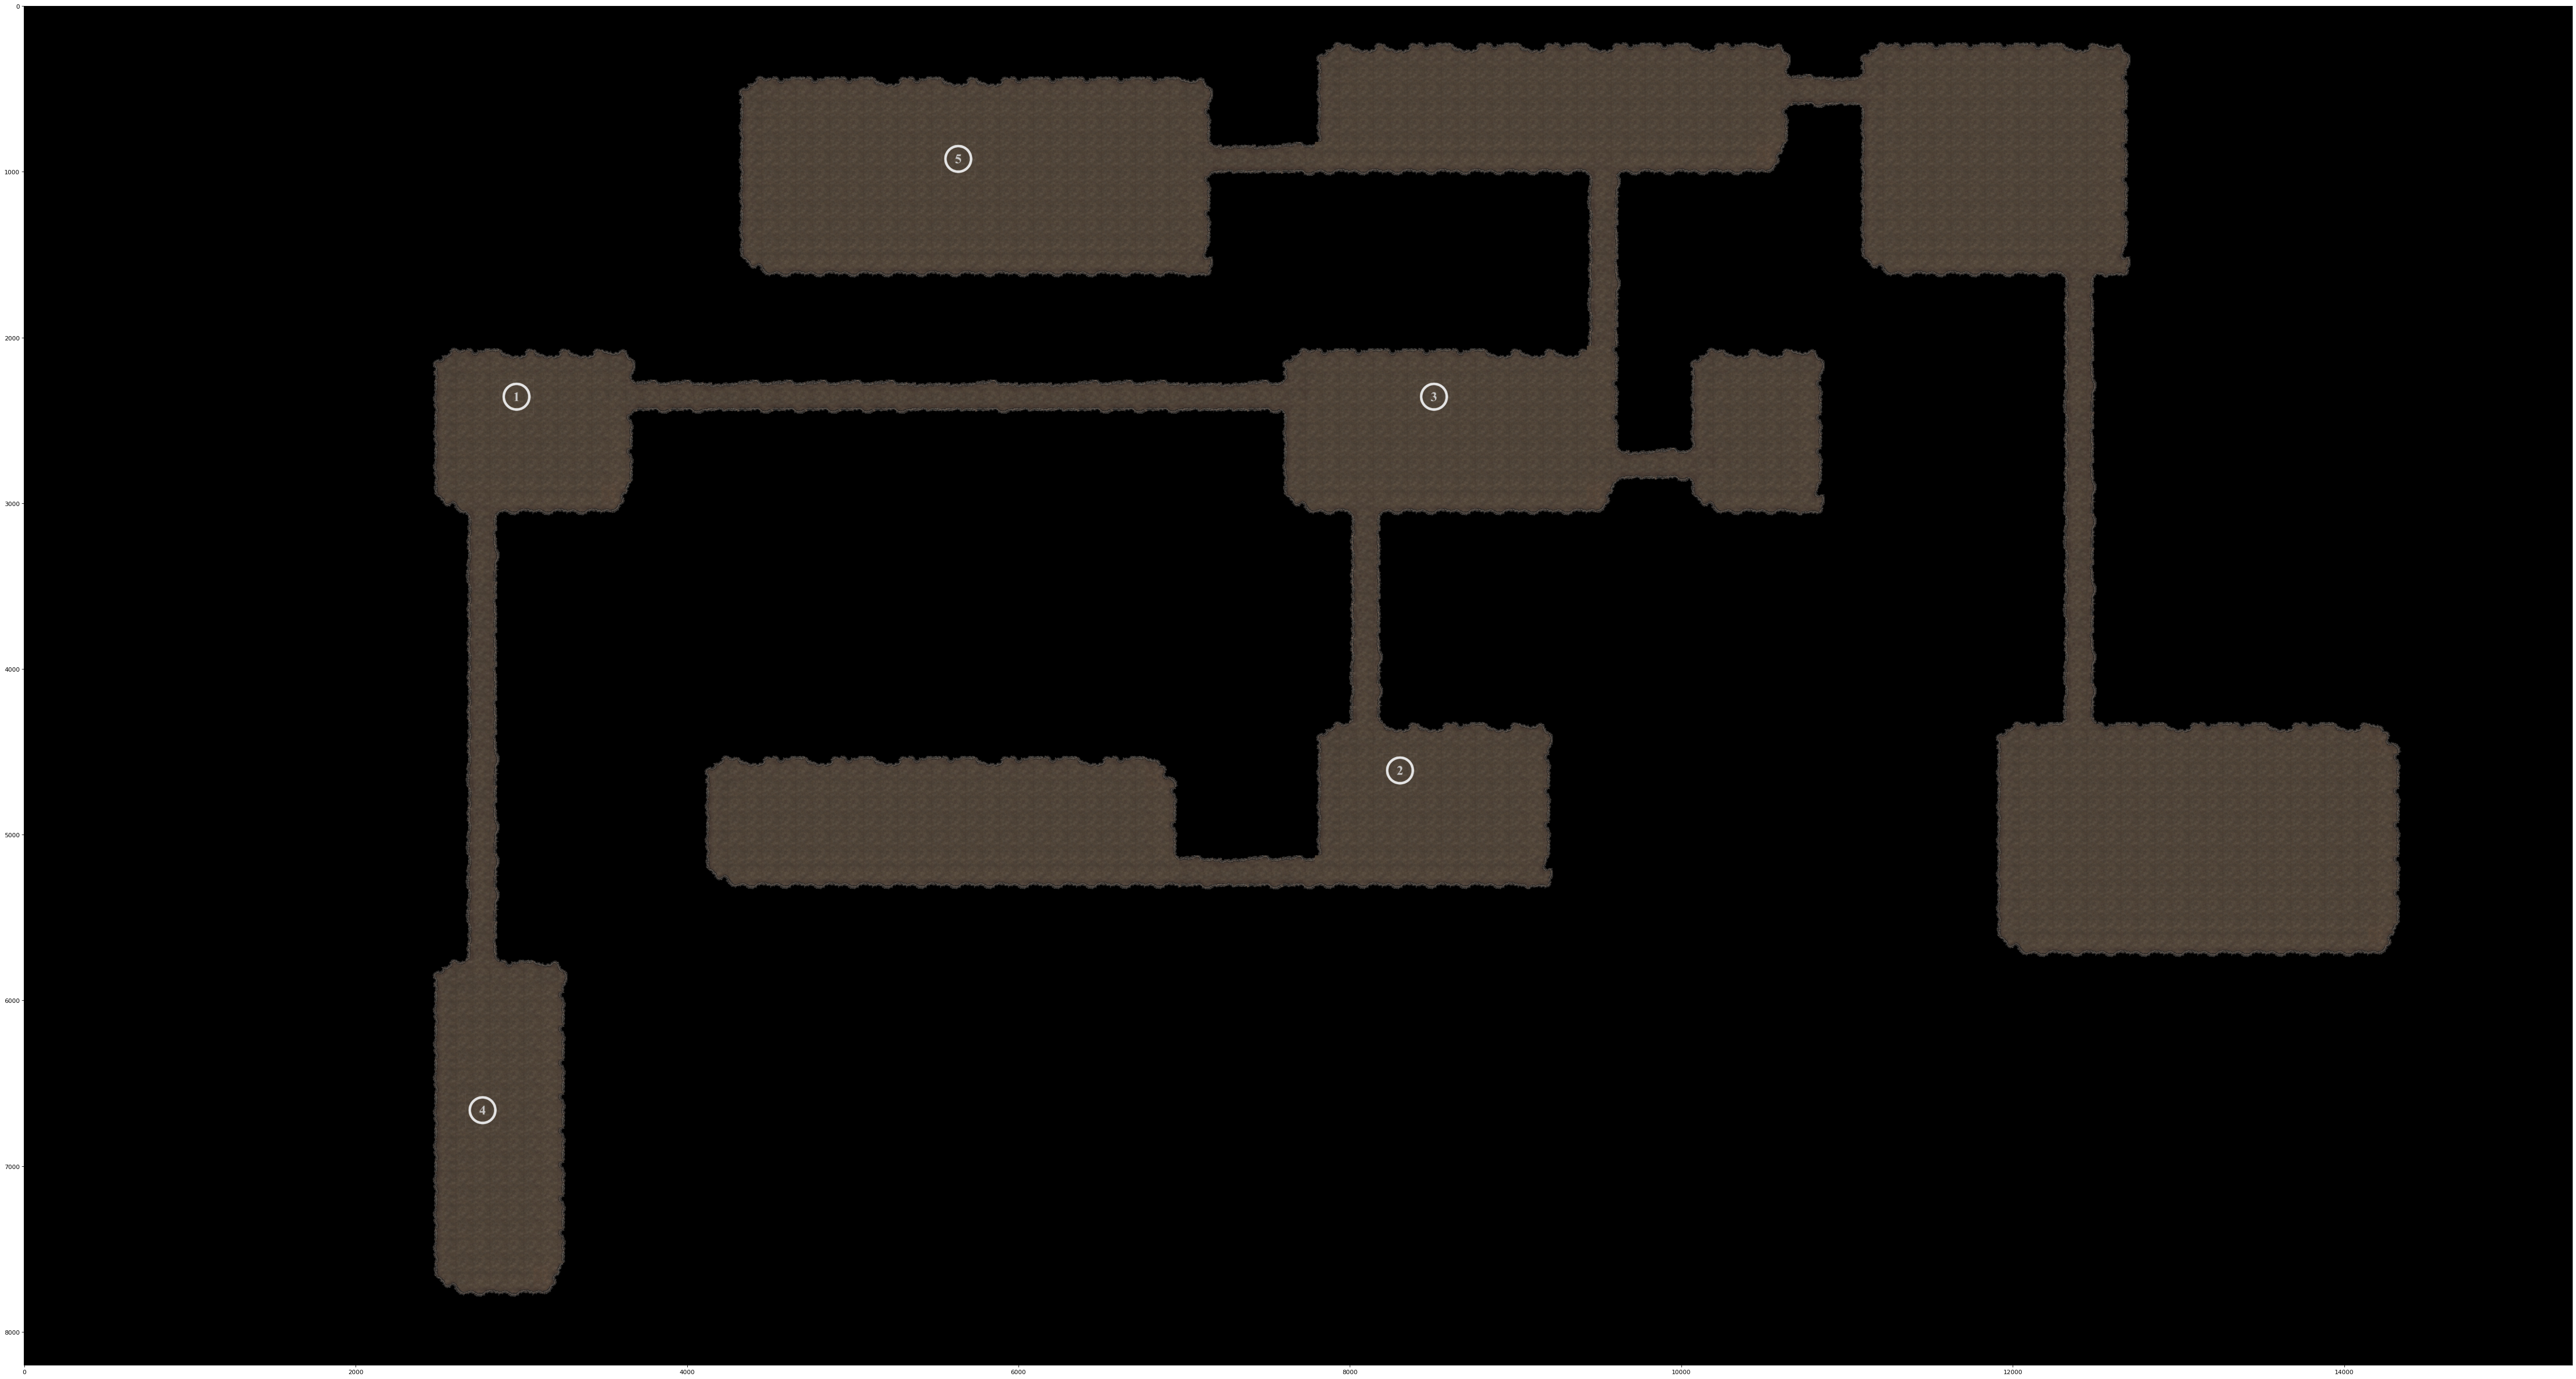


=====Total Number of Encounters=====
5

== Encounter 1 ==
2 Challenge 1   (200 XP)
1 Challenge 2   (450 XP)
1 Challenge 5   (1800 XP)
- Total Adjusted Encounter XP: 5300

== Encounter 2 ==
2 Challenge 1/4 (50 XP)
1 Challenge 1/2 (100 XP)
2 Challenge 1   (200 XP)
- Total Adjusted Encounter XP: 1200

== Encounter 3 ==
1 Challenge 4   (1100 XP)
1 Challenge 6   (2300 XP)
- Total Adjusted Encounter XP: 5100

== Encounter 4 ==
2 Challenge 1/4 (50 XP)
4 Challenge 1/2 (100 XP)
- Total Adjusted Encounter XP: 1000

== Encounter 5 ==
2 Challenge 1   (200 XP)
1 Challenge 6   (2300 XP)
- Total Adjusted Encounter XP: 5400

===== Total XP for the day =====
18000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

vCorridors = []
vCorridors.append(Image.open(drivePath + 'corridor_1a.jpg'))
vCorridors.append(Image.open(drivePath + 'corridor_1b.jpg'))

hCorridors = []
hCorridors.append(Image.open(drivePath + 'corridor_2a.jpg'))
hCorridors.append(Image.open(drivePath + 'corridor_2b.jpg'))

upperWalls = []
upperWalls.append(Image.open(drivePath + 'room_wall2.jpg'))
upperWalls.append(Image.open(drivePath + 'room_wall2b.jpg'))

bottomRightCorners = []
bottomRightCorners.append(Image.open(drivePath + 'room_corner1.jpg'))
bottomRightCorners.append(Image.open(drivePath + 'room_corner1b.jpg'))

topRightCorners = []
topRightCorners.append(Image.open(drivePath + 'room_corner2.jpg'))
topRightCorners.append(Image.open(drivePath + 'room_corner2b.jpg'))

def gallery(array, ncols=3):
    #automatically moves to new row based on number of columns
    #print(array.shape);
    nindex, dim, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

    #iterate through array generated by BSP and add appropriate tiles to input array for make_array()
    #syntax: [np.asarray(Image.open('/content/drive/MyDrive/CS4200 Tiles/room_corner3.jpg').convert('RGB'))]
mapArr = []    
for i in range(len(textMap)):
  for j in range(len(textMap[0])):
    #filling in empty space
    if textMap[i][j] == '0':
      mapArr.append([np.asarray(Image.open(drivePath + 'void.jpg').convert('RGB'))])

    #painting corridors  
    elif textMap[i][j] == '1':
      if textMap[i+1][j] == '1' or textMap[i-1][j] == '1' or textMap[i+1][j] == '.' or textMap[i-1][j] == '.':
        mapArr.append([np.asarray(vCorridors[shuffle(len(vCorridors))].convert('RGB'))])
      else:
        mapArr.append([np.asarray(hCorridors[shuffle(len(hCorridors))].convert('RGB'))])

    #placing encounter tokens
    elif textMap[i][j] == '2':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_1.png').convert('RGB'))])
    elif textMap[i][j] == '3':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_2.png').convert('RGB'))])
    elif textMap[i][j] == '4':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_3.png').convert('RGB'))])
    elif textMap[i][j] == '5':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_4.png').convert('RGB'))])
    elif textMap[i][j] == '6':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_5.png').convert('RGB'))])
    elif textMap[i][j] == '7':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_6.png').convert('RGB'))])
    elif textMap[i][j] == '8':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_7.png').convert('RGB'))])
    elif textMap[i][j] == '9':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_8.png').convert('RGB'))])
    elif textMap[i][j] == '10':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_9.png').convert('RGB'))])
    elif textMap[i][j] == '11':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_10.png').convert('RGB'))])
    elif textMap[i][j] == '12':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_11.png').convert('RGB'))])
    elif textMap[i][j] == '13':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_12.png').convert('RGB'))])
    elif textMap[i][j] == '14':
      mapArr.append([np.asarray(Image.open(drivePath + 'token_13.png').convert('RGB'))])


    #painting rooms
    elif textMap[i][j] == '.':
      #room corners
      #lower right
      if textMap[i + 1][j] == '0' and textMap [i][j+1] == '0' and textMap[i-1][j] == '.' and textMap [i][j - 1] == '.':
        mapArr.append([np.asarray(bottomRightCorners[shuffle(len(bottomRightCorners))].convert('RGB'))])
      #lower left  
      elif textMap[i + 1][j] == '.' and textMap [i][j+1] == '0' and textMap[i-1][j] == '0' and textMap [i][j - 1] == '.':
        mapArr.append([np.asarray(topRightCorners[shuffle(len(topRightCorners))].convert('RGB'))])
      #upper left
      elif textMap[i + 1][j] == '.' and textMap[i][j+1] == '.' and textMap[i-1][j] == '0' and textMap[i][j-1] == '0':
        mapArr.append([np.asarray(Image.open(drivePath + 'room_corner3.jpg').convert('RGB'))])
      #upper right
      elif textMap[i + 1][j] == '0' and textMap [i][j+1] == '.' and textMap[i-1][j] == '.' and textMap [i][j - 1] == '0':
        mapArr.append([np.asarray(Image.open(drivePath + 'room_corner4.jpg').convert('RGB'))])      
      

    #painting room walls
      #right wall
      elif textMap[i+1][j] == '.' and textMap[i][j+1] == '0':
        mapArr.append([np.asarray(Image.open(drivePath + 'room_wall1.jpg').convert('RGB'))])
      #top wall
      elif textMap[i-1][j] == '0' and textMap[i][j+1] == '.':
        mapArr.append([np.asarray(upperWalls[shuffle(len(upperWalls))].convert('RGB'))])
      #left wall  
      elif textMap[i+1][j] == '.' and textMap[i][j-1] == '0':
        mapArr.append([np.asarray(Image.open(drivePath + 'room_wall3.jpg').convert('RGB'))])
      #bottom wall
      elif textMap[i+1][j] == '0' and textMap[i][j+1] == '.':
        mapArr.append([np.asarray(Image.open(drivePath + 'room_wall4.jpg').convert('RGB'))])

    #painting room entrances
      #right entrance set
      elif textMap[i][j-1] == '.' and textMap [i][j+1] == '1':
          #right wall entrance
          if textMap[i+1][j] == '.' and textMap [i-1][j] == '.':
            mapArr.append([np.asarray(Image.open(drivePath + 'room_entrance1.jpg').convert('RGB'))])

          #bottom right corner entrance
          elif textMap[i+1][j] == '0':
            mapArr.append([np.asarray(Image.open(drivePath + 'Hcorner_entrance_bottomRight.jpg').convert('RGB'))])

          #top right corner entrance
          elif textMap[i-1][j] == '0':
            mapArr.append([np.asarray(Image.open(drivePath + 'Hcorner_entrance_topRight.jpg').convert('RGB'))])
          
      #top entrance set
      elif textMap[i + 1][j] == '.' and textMap [i-1][j] == '1':
        #top wall entrance
        if textMap[i][j-1] == '.' and textMap[i][j+1] == '.':
          mapArr.append([np.asarray(Image.open(drivePath + 'room_entrance2.jpg').convert('RGB'))])

        #top left corner entrance
        elif textMap[i][j-1] == '0':
          mapArr.append([np.asarray(Image.open(drivePath + 'Vcorner_entrance_topLeft.jpg').convert('RGB'))])

        #top right corner entrance
        elif textMap[i][j+1] == '0':
          mapArr.append([np.asarray(Image.open(drivePath + 'Vcorner_entrance_topRight.jpg').convert('RGB'))])

      #left entrance
      elif textMap[i][j+1] == '.' and textMap [i][j-1] == '1':
        #left wall entrance
        if textMap[i+1][j] == '.' and textMap[i-1][j] == '.':
          mapArr.append([np.asarray(Image.open(drivePath + 'room_entrance3.jpg').convert('RGB'))])

        #bottom left corner entrance
        elif textMap[i+1][j] == '0':
          mapArr.append([np.asarray(Image.open(drivePath + 'Hcorner_entrance_bottomLeft.jpg').convert('RGB'))])

        #top left corner entrance
        elif textMap[i-1][j] == '0':
          mapArr.append([np.asarray(Image.open(drivePath + 'Hcorner_entrance_topLeft.jpg').convert('RGB'))])  

      #bottom entrance
      elif textMap[i - 1][j] == '.' and textMap [i+1][j] == '1':
        #bottom wall entrance
        if textMap[i][j+1] == '.' and textMap[i][j-1] == '.':
          mapArr.append([np.asarray(Image.open(drivePath + 'room_entrance4.jpg').convert('RGB'))])
        
        #bottom left corner entrance
        elif textMap[i][j-1] == '0':
          mapArr.append([np.asarray(Image.open(drivePath + 'Vcorner_entrance_bottomLeft.jpg').convert('RGB'))]) 

        #bottom right corner entrance
        elif textMap[i][j+1] == '0':
          mapArr.append([np.asarray(Image.open(drivePath + 'Vcorner_entrance_bottomRight.jpg').convert('RGB'))])

    #painting floors    
      else:
        mapArr.append([np.asarray(Image.open(drivePath + 'floor.jpg').convert('RGB'))])

def make_array():    
    return np.array(mapArr)

array = make_array()
result = gallery(array, len(textMap[0]))

print("Dungeon map with suggested encounters:")
f = plt.figure(dpi=81)
f.set_figwidth(75)
f.set_figheight(75)
plt.imshow(result)
plt.show()

# Note: Encounters listed in the map array start from 2
# ie encounter 1 is displayed as 2 in the map array
print("\n=====Total Number of Encounters=====")
print(str(len(masterEncounterList))+ "\n")
printEncounters()
print("===== Total XP for the day =====")
print(str(int(totalXPearned)))